# <a id='toc1_'></a>[圖像分類中的對比學習](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [圖像分類中的對比學習](#toc1_)    
  - [引言](#toc1_1_)    
  - [對比學習的數學算法](#toc1_2_)    
    - [數據增強](#toc1_2_1_)    
    - [特徵嵌入](#toc1_2_2_)    
    - [對比損失（InfoNCE Loss）](#toc1_2_3_)    
  - [使用 CIFAR-10 數據集的實現](#toc1_3_)    
    - [數據集預覽與解說](#toc1_3_1_)    
    - [數據預處理與增強](#toc1_3_2_)    
    - [模型定義](#toc1_3_3_)    
    - [對比損失函數](#toc1_3_4_)    
    - [訓練過程](#toc1_3_5_)    
    - [驗證過程](#toc1_3_6_)    
    - [部署與推論](#toc1_3_7_)    
  - [總結](#toc1_4_)    
  - [Appendix](#toc1_5_)    
    - [使用較大的資料集來訓練](#toc1_5_1_)    
      - [資料集擴展與預處理](#toc1_5_1_1_)    
      - [調整數據增強策略](#toc1_5_1_2_)    
      - [模型選擇](#toc1_5_1_3_)    
      - [訓練策略調整](#toc1_5_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->




## <a id='toc1_1_'></a>[引言](#toc0_)

**對比學習（Contrastive Learning）** 是一種自監督學習方法，旨在學習數據之間的相似性和差異性。其核心思想是：

- **正樣本對（Positive Pair）**：相似的樣本（如同一圖像的不同增強版本）。
- **負樣本對（Negative Pair）**：不相似的樣本（如不同圖像）。

模型學習將正樣本對的嵌入表示靠近，將負樣本對的嵌入表示推遠。

在圖像分類中，對比學習可以在無監督的情況下學習到有用的圖像特徵，從而提升分類性能。

---

## <a id='toc1_2_'></a>[對比學習的數學算法](#toc0_)

### <a id='toc1_2_1_'></a>[數據增強](#toc0_)

給定一個圖像 $x$，應用兩種隨機數據增強方法，得到兩個視圖 $x_i$ 和 $x_j$。

### <a id='toc1_2_2_'></a>[特徵嵌入](#toc0_)

使用神經網絡 $f(\cdot)$ 將增強後的圖像映射到嵌入空間：

$$
z_i = f(x_i), \quad z_j = f(x_j)
$$

### <a id='toc1_2_3_'></a>[對比損失（InfoNCE Loss）](#toc0_)

對比損失旨在最小化正樣本對之間的距離，最大化負樣本對之間的距離。

損失函數定義為：

$$
\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k)/\tau)}
$$

- $\text{sim}(z_i, z_j)$ 是嵌入之間的相似度（通常為餘弦相似度）。
- $\tau$ 是溫度參數，控制分佈的鋒利程度。
- $N$ 是批次大小。

總損失為所有正樣本對損失的平均：

$$
\mathcal{L} = \frac{1}{2N} \sum_{k=1}^{N} [\ell_{2k-1,2k} + \ell_{2k,2k-1}]
$$

---

## <a id='toc1_3_'></a>[使用 CIFAR-10 數據集的實現](#toc0_)

我們將使用 PyTorch 來實現對比學習，數據集選擇經典的 **CIFAR-10**。

### <a id='toc1_3_1_'></a>[數據集預覽與解說](#toc0_)

**CIFAR-10** 是一個包含 60000 張 32x32 彩色圖像的數據集，分為 10 個類別，每類有 6000 張圖像。其中，50000 張用於訓練，10000 張用於測試。

以下是 CIFAR-10 的一些樣本圖像：


Files already downloaded and verified


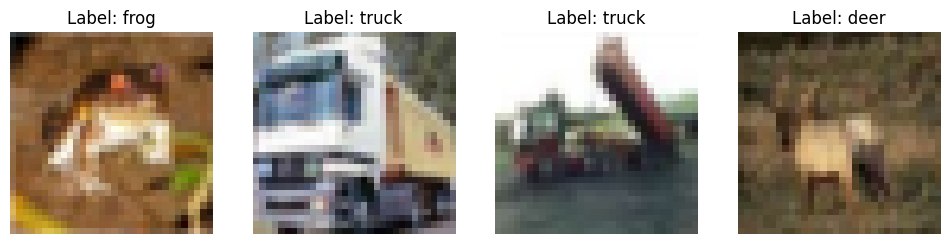

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# 定義數據轉換（僅轉為Tensor，無增強）
transform = transforms.Compose([
    transforms.ToTensor()
])

# 加載訓練數據集
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 選取前 4 張圖像進行展示
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for idx, (image, label) in enumerate(train_dataset):
    if idx >= 4:
        break
    image = image.numpy().transpose((1, 2, 0))
    axes[idx].imshow(image)
    axes[idx].set_title(f"Label: {train_dataset.classes[label]}")
    axes[idx].axis('off')
plt.show()

**解說**：

- 使用 `transforms.ToTensor()` 將圖像轉換為 Tensor。
- 使用 `plt.imshow()` 顯示圖像，並在標題中顯示其類別。

### <a id='toc1_3_2_'></a>[數據預處理與增強](#toc0_)

對比學習需要對圖像進行隨機增強，以生成正樣本對。

In [14]:
from torchvision import transforms

# 定義數據增強方法
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # 隨機調整亮度、對比度、飽和度和色調
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

**解說**：

- `RandomResizedCrop`：隨機裁剪圖像為指定大小。
- `RandomHorizontalFlip`：隨機水平翻轉圖像。
- `ColorJitter`：隨機改變圖像的亮度、對比度、飽和度和色調。
- `RandomGrayscale`：以一定概率將圖像轉為灰度圖。
- 這些增強方法有助於模型學習到更加魯棒的特徵。

### <a id='toc1_3_3_'></a>[模型定義](#toc0_)

使用簡化的 ResNet 作為基礎網絡，並添加投影頭將特徵映射到嵌入空間。

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetSimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.backbone = base_model(pretrained=False)
        num_ftrs = self.backbone.fc.in_features
        # 移除原始分類頭
        self.backbone.fc = nn.Identity()
        # 添加投影頭
        self.projection_head = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.Linear(num_ftrs, out_dim)
        )
        
    def forward(self, x):
        h = self.backbone(x)
        z = self.projection_head(h)
        return F.normalize(z, dim=1)

**解說**：

- 使用 `resnet18` 作為基礎模型。
- 將最後的全連接層替換為身份映射，以獲取特徵向量。
- 添加一個投影頭（兩層全連接層）將特徵映射到對比學習的嵌入空間。
- 使用 `F.normalize` 將嵌入向量進行歸一化。

### <a id='toc1_3_4_'></a>[對比損失函數](#toc0_)


In [16]:
def NT_XentLoss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)  # [2N, D]
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # [2N, 2N]

    # 創建正樣本對的標籤
    mask = torch.eye(2*batch_size, dtype=torch.bool).to(z.device)
    positive_mask = torch.cat([torch.zeros(batch_size, batch_size), torch.eye(batch_size)], dim=1)
    positive_mask = torch.cat([positive_mask, positive_mask.flip(0)], dim=0).to(z.device)

    sim_matrix = sim_matrix / temperature
    sim_matrix = sim_matrix.masked_fill(mask, -1e9)  # 避免自身匹配

    positives = sim_matrix[positive_mask.bool()].view(2*batch_size, -1)
    negatives = sim_matrix[~positive_mask.bool()].view(2*batch_size, -1)

    labels = torch.zeros(positives.size(0), dtype=torch.long).to(z.device)
    logits = torch.cat([positives, negatives], dim=1)

    loss = F.cross_entropy(logits, labels)
    return loss

**解說**：

- **相似度矩陣**：計算所有樣本之間的餘弦相似度，得到 [2N, 2N] 的矩陣。
- **遮罩**：使用掩碼避免計算自身與自身的相似度。
- **正負樣本**：從相似度矩陣中提取正樣本對和負樣本對的相似度。
- **損失計算**：使用交叉熵損失，將正樣本的標籤設為 0，負樣本的標籤設為 1。

### <a id='toc1_3_5_'></a>[訓練過程](#toc0_)

In [17]:
import torch.optim as optim
from torchvision import models

# 初始化模型、優化器和損失函數
model = ResNetSimCLR(base_model=models.resnet18, out_dim=128).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 加載數據集
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

# 訓練迴圈
for epoch in range(1, 11):
    model.train()
    total_loss = 0
    for idx, (images, _) in enumerate(train_loader):
        images = torch.cat([images, images], dim=0)  # 擴充為 2N
        images = images.cuda()
        # 前向傳播
        z = model(images)
        z_i, z_j = torch.split(z, images.size(0)//2, dim=0)
        loss = NT_XentLoss(z_i, z_j)
        # 反向傳播與優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if idx % 100 == 0:
            print(f"Epoch [{epoch}/{10}], Step [{idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
    print(f"Epoch [{epoch}/{10}], Average Loss: {total_loss/len(train_loader):.4f}")

Files already downloaded and verified
Epoch [1/10], Step [0/196], Loss: 5.8327
Epoch [1/10], Step [100/196], Loss: 5.3284
Epoch [1/10], Average Loss: 5.3319
Epoch [2/10], Step [0/196], Loss: 5.3367
Epoch [2/10], Step [100/196], Loss: 5.3387
Epoch [2/10], Average Loss: 5.3134
Epoch [3/10], Step [0/196], Loss: 5.3137
Epoch [3/10], Step [100/196], Loss: 5.3262
Epoch [3/10], Average Loss: 5.3088
Epoch [4/10], Step [0/196], Loss: 5.3157
Epoch [4/10], Step [100/196], Loss: 5.3193
Epoch [4/10], Average Loss: 5.3027
Epoch [5/10], Step [0/196], Loss: 5.3113
Epoch [5/10], Step [100/196], Loss: 5.3005
Epoch [5/10], Average Loss: 5.3020
Epoch [6/10], Step [0/196], Loss: 5.2908
Epoch [6/10], Step [100/196], Loss: 5.3048
Epoch [6/10], Average Loss: 5.2993
Epoch [7/10], Step [0/196], Loss: 5.3008
Epoch [7/10], Step [100/196], Loss: 5.2839
Epoch [7/10], Average Loss: 5.2972
Epoch [8/10], Step [0/196], Loss: 5.3120
Epoch [8/10], Step [100/196], Loss: 5.2898
Epoch [8/10], Average Loss: 5.2944
Epoch [9/1

**解說**：

- **模型初始化**：使用 `ResNetSimCLR`，設置輸出維度為 128。
- **優化器**：使用 Adam 優化器。
- **數據加載**：使用之前定義的增強方法。
- **訓練迴圈**：
  - 合併兩個增強版本的圖像，形成 2N 的批次。
  - 前向傳播，得到嵌入表示 \( z \)，然後分割成 \( z_i \) 和 \( z_j \)。
  - 計算對比損失，反向傳播和優化。
  - 每隔 100 個步驟打印一次損失。

### <a id='toc1_3_6_'></a>[驗證過程](#toc0_)

由於對比學習是無監督的，我們需要在下游任務中驗證模型的性能。

這裡，我們使用線性分類器在凍結的特徵上進行訓練，以評估模型的特徵學習效果。

In [18]:
# 定義線性分類器
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(feature_dim, num_classes)
        
    def forward(self, x):
        return self.fc(x)

# 凍結基礎模型的參數
for param in model.parameters():
    param.requires_grad = False

# 初始化分類器和優化器
classifier = LinearClassifier(feature_dim=512, num_classes=10).cuda()  # ResNet-18 的輸出維度為 512
criterion = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=1e-3)

# 加載訓練和測試數據集（不進行數據增強）
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_cls = datasets.CIFAR10(root='./data', train=True, transform=test_transform, download=True)
test_dataset_cls = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)
train_loader_cls = torch.utils.data.DataLoader(train_dataset_cls, batch_size=256, shuffle=True, num_workers=4)
test_loader_cls = torch.utils.data.DataLoader(test_dataset_cls, batch_size=256, shuffle=False, num_workers=4)

# 訓練線性分類器
for epoch in range(1, 11):
    classifier.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader_cls:
        images = images.cuda()
        labels = labels.cuda()
        with torch.no_grad():
            features = model.backbone(images)
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    print(f"Epoch [{epoch}/10], Loss: {total_loss/len(train_loader_cls):.4f}, Accuracy: {100.*correct/total:.2f}%")

# 測試分類器
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_cls:
        images = images.cuda()
        labels = labels.cuda()
        features = model.backbone(images)
        outputs = classifier(features)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
print(f"Test Accuracy: {100.*correct/total:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 2.0578, Accuracy: 25.46%
Epoch [2/10], Loss: 1.9824, Accuracy: 28.15%
Epoch [3/10], Loss: 1.9626, Accuracy: 28.84%
Epoch [4/10], Loss: 1.9503, Accuracy: 29.35%
Epoch [5/10], Loss: 1.9385, Accuracy: 29.88%
Epoch [6/10], Loss: 1.9331, Accuracy: 29.91%
Epoch [7/10], Loss: 1.9267, Accuracy: 30.48%
Epoch [8/10], Loss: 1.9219, Accuracy: 30.59%
Epoch [9/10], Loss: 1.9173, Accuracy: 30.98%
Epoch [10/10], Loss: 1.9126, Accuracy: 30.97%
Test Accuracy: 30.93%


**解說**：

- **線性分類器**：僅包含一個全連接層。
- **凍結特徵提取器**：停止對 `model` 的更新，只訓練分類器。
- **訓練過程**：
  - 提取圖像的特徵。
  - 使用分類器進行預測，計算損失，進行優化。
  - 計算訓練精度。
- **測試過程**：
  - 在測試集上評估模型的分類精度。

### <a id='toc1_3_7_'></a>[部署與推論](#toc0_)

在部署階段，我們可以使用訓練好的模型進行圖像分類。

In [19]:
# 單張圖像的推論
def predict(image_path):
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = transform(image).unsqueeze(0).cuda()
    with torch.no_grad():
        features = model.backbone(image)
        outputs = classifier(features)
        _, predicted = outputs.max(1)
    return train_dataset.classes[predicted.item()]

# 測試推論
image_path = './data/cifar-10-batches-py/test_batch'  # 替換為實際的圖像路徑
prediction = predict(image_path)
print(f"Predicted class: {prediction}")


UnidentifiedImageError: cannot identify image file '/home/cosmo/side_project/NLP-ViT-tutorial/6-1.Contrastive-Learning/data/cifar-10-batches-py/test_batch'

**解說**：

- **圖像預處理**：將圖像調整為模型所需的輸入格式。
- **特徵提取**：使用訓練好的特徵提取器獲取圖像特徵。
- **分類**：使用分類器進行預測，輸出類別。

---

## <a id='toc1_4_'></a>[總結](#toc0_)

本文詳細介紹了對比學習在圖像分類中的應用，包括數學算法、程式碼實現和詳細的解說。我們使用了經典的 CIFAR-10 數據集，展示了如何進行數據增強、模型定義、損失計算、訓練、驗證和推論。

通過對比學習，模型能夠在無監督的情況下學習到有用的特徵，並在下游的分類任務中取得不錯的性能。

---

**注意**：在實際應用中，可以調整模型的複雜度、增強方法和訓練策略，以獲得更好的性能。此外，對比學習的效果在較大的數據集（如 ImageNet）上會更加明顯。

## <a id='toc1_5_'></a>[Appendix](#toc0_)

### <a id='toc1_5_1_'></a>[使用較大的資料集來訓練](#toc0_)

如果要使用更大的資料集來訓練這個對比學習模型，可以選擇類似 **ImageNet** 或 **Places365** 等較大型的圖像資料集。這些資料集比 CIFAR-10 更具挑戰性，且擁有高解析度的圖像，適合進一步提升模型的特徵學習能力。以下是一些建議：

#### <a id='toc1_5_1_1_'></a>[資料集擴展與預處理](#toc0_)
- **ImageNet**：這是一個包含約 1400 萬張圖像，並標記了 1000 類別的大型圖像資料集。在 PyTorch 中可以使用 `torchvision.datasets.ImageNet` 來加載。
- **Places365**：這個資料集主要用於場景識別，包含 365 種場景類別，約 180 萬張訓練圖像和 36500 張測試圖像。

#### <a id='toc1_5_1_2_'></a>[調整數據增強策略](#toc0_)
由於較大資料集的圖像解析度更高，可以使用更複雜的數據增強方法，例如：
```python
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 使用 ImageNet 的標準均值和方差
])
```

#### <a id='toc1_5_1_3_'></a>[模型選擇](#toc0_)
考慮使用更深層的模型，如 **ResNet-50** 或 **ResNet-101**，以提高模型的表現。這些模型具有更大的容量，能夠捕捉更豐富的特徵。
```python
from torchvision import models

model = ResNetSimCLR(base_model=models.resnet50, out_dim=128).cuda()
```

#### <a id='toc1_5_1_4_'></a>[訓練策略調整](#toc0_)
由於資料集變大，訓練時間會增加，建議使用以下技術來加速訓練：
- **混合精度訓練**：使用 `torch.cuda.amp` 來進行混合精度訓練，可以顯著提升速度並減少顯存使用。
- **分佈式訓練**：使用多個 GPU 或多個節點進行分佈式訓練，以加快訓練過程。

如果你有其他需求或需要幫助來適配更大資料集的代碼，隨時告訴我！